## STOCK PREDICTION - LSTM method


<p> In this section, the user will be presented with predictions of the evolution on stock´s ******* ---> Close price ********. Reader (assuming he is as a stock buyer) can use the model predictions to help him decide when to buy or sell the stocks. However, it should be noted that stock market prices are highly volatile with no consistent patterns and that makes stock prices modelling difficult. It is impossible to model stock prices over time near-perfectly but scientists are not discouraged by this. There are many approaches on stock´s prices prediction computation. We decided to use two short-term measures - standard averaging (STA) and exponential moving average (EMA) -  and one long-term - LSTM (Long Short-Term Memory). This file will focus on long-term predicting via LSTM model.  </p>

<p>While averaging methods are used for predicting the next one point in time value, LSTM approach predicts future sequence of values (usually 30 days). Compared to STA and EMA predictions, we decided that the output of LSTM model will be presented graphically rather than numerically since we believe it is more informative to see the sequence of predicted values in a graph than in a table. In this file, we will predict the evolution of stock´s Closing price for 30 days in the future. </p>

<p>There are various ways how to predict number of steps in the future. We decided to employ LSTM model. It is a machine learning model that can be applied in sequence prediction problems. The basic idea is/it based on....define training/testing + input/output? to train your model..............</p>

**Note**: The models are not "golden rule" you should follow no matter what. It is important to understand that those models provide some sort of guidance on how the stock market might develop and also help you understand the market. Nevertheless, it is not wise to base your investment strategy solely on the predictions given by the models and we as authors of this project definitely do not encourage you to do so.

**Disclaimer**: The mathematical methods and approaches used in the prediction analyses employed by authors of this project are based on the measures standardly used in the research area. The LSTM prediction is based on DataCamp LSTM stock market prediction tutorial, Predicting Sequential Data using LSTM: An Introduction by George V Jose and Stock Price Prediction And Forecasting Using Stacked LSTM tutorial by Krish Naik. Thus, the authors do not claim the procedures used are their own inventions and do not take any credit for them.

Issues with tensorflow package...It may happen that when installing the tensorflow package (if you already do not have one installed), you may encounter an error of the following fashion *Could not install packages due to an EnvironmentError: [WinError 5] Access is denied:* . There are two possible solutions to this problem. Firstly, you run the following command: "pip install tensorflow --user". Or secondly, you should change the access permission, where the particular package is going to install. In either case, after you run the command/modify access permission, it is better to close the command line (or e.g. Jupyter Notebook), open new one and try to install the package again.

Firstly, import the packages we will need for our analysis

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import keras 

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

In [1]:
#TDS

import pandas as pd
import numpy as np
import yfinance as yf
import keras 
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense

# už nepotřebuju???
import plotly.graph_objects as go # for graph with plotly
import matplotlib.pyplot as plt # for graph
from sklearn.preprocessing import MinMaxScaler

In [2]:
# DC

import numpy as np
import yfinance as yf
import pandas as pd

#import tensorflow as tf
#POZN: import tensorflow as tf mi házelo později při "Defining Inputs and Outputs" tento error: (paseku tam dělalo tf.placeholder)
# AttributeError: module 'tensorflow' has no attribute 'placeholder'
# vyřešilo se následovně:
#replace
#import tensorflow as tf
#by
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()



from sklearn.preprocessing import MinMaxScaler

Instructions for updating:
non-resource variables are not supported in the long term


Next, we defince the ticker for which the LSTM prediction will be conducted. We used "GOOGL" (i.e. Google) as a default ticker but you can obviously change it and choose your own - just adjust the following line of code: *tickerSymbol = 'GOOGL'*.

In [271]:
#TDS

#define the ticker symbol
tickerSymbol = 'GOOGL'
#get data on this ticker
tickerData = yf.Ticker(tickerSymbol)
#get the historical prices for this ticker
df = tickerData.history(period='1d', start='2015-5-31', end='2020-5-31')

# adding idx column, so we have st. for X-asix in graph instead of date (because for now, we use yfinance where we do not have "Date" column available)
df["idx"] = range(1, len(df)+1)

In [201]:
#see how the dataset looks like
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,idx
Date,,,,,,,,
2015-06-01,548.729980,550.570007,543.580017,549.210022,1660500,0,0,1
2015-06-02,547.429993,558.789978,546.549988,553.950012,1592100,0,0,2
2015-06-03,555.099976,557.989990,552.150024,555.289978,1335500,0,0,3
2015-06-04,552.179993,555.960022,549.119995,551.690002,1343300,0,0,4
2015-06-05,552.000000,553.330017,547.380005,549.530029,1219800,0,0,5
...,...,...,...,...,...,...,...,...
2020-05-22,1403.900024,1417.000000,1395.949951,1413.239990,1427200,0,0,1255
2020-05-26,1441.959961,1445.109985,1419.400024,1421.369995,2229500,0,0,1256
2020-05-27,1420.000000,1425.349976,1394.599976,1420.280029,1584200,0,0,1257


Now, we need to make some modifications to the dataset so that we can work with it further. In this section, we split it into training set and testing set, rescale (normalize) it and also reshape.

**NOTE**: It is very important to stress out here that LSTM models are quite sensitive to the scale of the data. Therefore, we will transform (normalize) our data into 0-1 scale with MinMaxScaler.

In [289]:
#TDS
# split používám z TDS (tam nedělají 0-1 scale)
# EDIT: stejně musím 0-1 scale udělat...


# take only Close prices - we will focus on those
close_data = df['Close'].values
#close_data = close_data.reshape((-1,1))


# determine the split proportion of training vs testing
split_percent = 0.80
split = int(split_percent*len(close_data))
# train/test sample to be included in the graphs with the predicted values
close_train_orig = close_data[:split]
close_test_orig = close_data[split:]
close_data_orig = close_data

# NOTE: LSTM are sensitive to the scale of the data. so we need to apply MinMax scaler to transform our data into 0-1 scale
# mám už nahoře
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
close_data_reshaped_scaled=scaler.fit_transform(np.array(df['Close'].values).reshape(-1,1))
close_data=close_data_reshaped_scaled

# train/test sample used in the LSTM modelling
close_train = close_data[:split]
close_test = close_data[split:]

#POZN: takhle by měly dates vypadat až budu používat DataReader, ale pro teď s yfinance použiju indexy
#date_train = df['Date'][:split]
#date_test = df['Date'][split:]

date_train = df['idx'][:split]
date_test = df['idx'][split:]

print(len(close_train))
print(len(close_test))

1007
252


In [275]:
# train/test jména upravená, aby seděla na Class DataGeneratorSeq z DC
train_data=close_train
test_data=close_test

In [ ]:
## ---------- zatím NOT RUN -------------------
#DC split, normalize a reshape

# reshape
# normalize to 0-1 scale
# train x test split

#we will be working only with "Close prices"
close_data=tickerDf["Close"].values

#next, reshape 
close_data = close_data.reshape((-1,1))


#next, transform the data to 0-1 scale as LSTM are sensitive to the scale of the data
from sklearn.preprocessing import MinMaxScaler  # we also have at the beginning
scaler=MinMaxScaler(feature_range=(0,1))
close_data=scaler.fit_transform(np.array(close_data).reshape(-1,1))



# selecting 80:20 split (80% training, 20% testing)
split_percent = 0.80
split = int(split_percent*len(close_data))

train_data = close_data[:split]
test_data = close_data[split:]

#zatím nepoužívat, protože přes yfinance nemám Date jako samostatný sloupec, přes DataReader ano - zjistit od Aničky přesný název sloupců - close/Close/Date/date??? atd..
#date_train = tickerDf['Date'][:split]
#date_test = tickrDf['Date'][split:]

print(len(train_data))
print(len(test_data))

Here, we define data generator that will help us to train the LSTM model. DataGeneratorSeq creates batches of input and output data whose number is based on *num_unroll* parameter.

In [376]:
# DC
# define data generator that will train your model


class DataGeneratorSeq(object):

    def __init__(self,prices,batch_size,num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next_batch(self):

        batch_data = np.zeros((self._batch_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)

        for b in range(self._batch_size):
            if self._cursor[b]+1>=self._prices_length:
                #self._cursor[b] = b * self._segments
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)

            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(0,5)]

            self._cursor[b] = (self._cursor[b]+1)%self._prices_length

        return batch_data,batch_labels

    def unroll_batches(self):

        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):

            data, labels = self.next_batch()    

            unroll_data.append(data)
            unroll_labels.append(labels)

        return unroll_data, unroll_labels

    def reset_indices(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))



dg = DataGeneratorSeq(train_data,100,120)
u_data, u_labels = dg.unroll_batches()

for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
    print('\n\nUnrolled index %d'%ui)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs: ',dat )
    print('\n\tOutput:',lbl)



Unrolled index 0
	Inputs:  [0.0093113  0.01015404 0.02370971 0.00566597 0.06269107 0.12146258
 0.12626548 0.15637216 0.10944024 0.11703543 0.11499447 0.13366775
 0.1553365  0.19574955 0.22497283 0.22335838 0.24750464 0.21362063
 0.23198931 0.2226679  0.1817979  0.22471899 0.16937949 0.1799803
 0.19310945 0.22066753 0.22932896 0.22281002 0.23849802 0.17705593
 0.19092637 0.1959628  0.19294702 0.18704753 0.15354937 0.19004299
 0.21767208 0.2640862  0.27112293 0.25746575 0.2721079  0.26190305
 0.2741793  0.27835262 0.28592753 0.26952875 0.2352792  0.24264088
 0.23977743 0.27395594 0.26688874 0.29428428 0.31425732 0.28440443
 0.30185923 0.30958644 0.32632026 0.31453145 0.32158852 0.30476326
 0.35447747 0.42509878 0.41678262 0.45393625 0.42826682 0.44330496
 0.39826167 0.44263482 0.41882357 0.41037542 0.392088   0.4098068
 0.41287333 0.4094311  0.4333134  0.47653908 0.4583329  0.5202421
 0.50348794 0.50377226 0.51656634 0.5369658  0.579034   0.6051095
 0.64714724 0.51402783 0.57863796 0.5

In [144]:
u_data

[array([241.42642, 232.26727, 301.94696, 307.45245, 269.54956, 309.7998 ,
        296.13614, 311.54153, 323.78378, 280.63065, 355.34534, 348.7888 ,
        416.7167 , 435.81583, 435.1001 , 506.3964 , 580.56055, 538.53   ,
        603.01   , 540.73   , 506.91   , 541.31   , 557.95   , 671.67   ,
        762.55   , 730.22   , 736.93   , 802.75   , 805.59   , 820.13   ],
       dtype=float32),
 array([246.93193, 225.92091, 298.03302, 309.4995 , 267.21222, 311.57156,
        291.4965 , 311.8819 , 321.63162, 282.62262, 359.4995 , 349.12912,
        416.17618, 436.04605, 437.2923 , 516.7518 , 589.3093 , 533.87   ,
        598.08   , 536.92   , 500.72   , 543.95   , 553.06   , 660.92   ,
        760.04   , 712.8    , 747.6    , 799.65   , 780.29   , 821.62   ],
       dtype=float32),
 array([253.05305, 227.53754, 292.15216, 308.55856, 268.16318, 303.9139 ,
        295.55054, 313.2933 , 317.89288, 284.93494, 364.1141 , 351.7017 ,
        417.82782, 434.24924, 435.54053, 518.1331 , 587.05206, 5

In [377]:
# make sure that u_data is np.array and denote it as "train_generator2"
train_generator2=np.array(u_data)
print(train_generator2.ndim)
type (train_generator2)

# next, reshape (because we need 3 dimensions in the model)
#train_generator2 = train_generator2.reshape(train_generator2.shape[0], 1, train_generator2.shape[1])
train_generator2 = train_generator2.reshape(train_generator2.shape[0], train_generator2.shape[1], 1)
print(train_generator2.ndim)

2
3


In [138]:
train_generator2

array([[[ 241.42642,  231.82182,  293.86386,  285.28027,  250.43544,
          273.5886 ,  315.16516,  324.52954,  294.2092 ,  384.2092 ,
          361.987  ,  400.33533,  451.90192,  508.1081 ,  591.07605,
          518.     ,  577.25   ,  558.25   ,  546.45   ,  547.19   ,
          667.96   ,  783.79   ,  713.53   ,  733.19   ,  790.46   ,
          809.84   ,  835.14   ,  961.01   ,  967.47   , 1110.29   ]],

       [[ 246.93193,  235.38539,  295.56555,  285.06506,  242.75275,
          269.86987,  316.8869 ,  320.94095,  298.25827,  379.2993 ,
          362.82782,  400.45544,  444.29428,  508.008  ,  567.2823 ,
          520.17   ,  572.12   ,  556.44   ,  541.8    ,  554.25   ,
          659.69   ,  777.85   ,  725.41   ,  731.88   ,  801.23   ,
          812.5    ,  838.51   ,  937.82   ,  972.08   , 1114.21   ]],

       [[ 253.05305,  232.43243,  296.04605,  278.82883,  242.53253,
          260.59058,  320.44543,  323.78378,  293.2833 ,  372.41742,
          357.95294,  404.35

In [108]:
type (test_generator2)

numpy.ndarray

In [378]:
# make sure that u_data is np.array and denote it as "test_generator2"
test_generator2=np.array(u_labels)
print(test_generator2.ndim)
type (test_generator2)

# next, reshape (because we need 3 dimensions in the model)
#test_generator2 = test_generator2.reshape(test_generator2.shape[0], 1, test_generator2.shape[1])
test_generator2 = test_generator2.reshape(test_generator2.shape[0],test_generator2.shape[1], 1)
print(test_generator2.ndim)

2
3


In [96]:
test_generator2

array([[[ 249.6096 ,  296.4014 ,  246.74675,  333.03802,  285.5255 ,
          377.48248,  452.95294,  593.93896,  592.54   ,  572.9    ,
          652.47   ,  757.56   ,  802.79   ,  853.99   ,  988.49   ]],

       [[ 246.93193,  296.04605,  237.67767,  329.83484,  285.5255 ,
          377.21722,  452.95294,  593.93896,  588.12   ,  572.9    ,
          652.47   ,  765.89   ,  800.71   ,  853.99   ,  991.42   ]],

       [[ 249.6096 ,  296.15115,  240.35036,  325.33533,  287.74774,
          377.48248,  445.77078,  602.002  ,  580.32   ,  561.17   ,
          665.52   ,  769.67   ,  800.71   ,  856.51   , 1033.67   ]],

       [[ 237.24725,  296.15115,  249.03403,  325.33533,  290.6707 ,
          377.21722,  445.65067,  602.002  ,  582.36   ,  561.17   ,
          666.98   ,  762.9    ,  809.57   ,  860.08   ,  991.46   ]],

       [[ 243.74875,  296.15115,  249.03403,  311.8819 ,  290.6707 ,
          377.21722,  445.65067,  606.046  ,  589.52   ,  561.64   ,
          666.98   ,  

In [ ]:
#TDS

# define the look back + transform the data
look_back = 15

train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=20)     
test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=1)

Our data is finally ready, so we are able to continue with creating and training the network. As regards the LSTM parameters, we follow what is typical for LSTM stock prediction and use Adam optimizer and Mean Squared Loss function with 150 epochs.

In [379]:
#TDS
# sem vkládám train_generator vytvořený pomocí TimeseriesGenerator - na posledním řádku
# mám i na začátku
from keras.models import Sequential
from keras.layers import LSTM, Dense



# musím definovat zde, pokud nepoužiju TimeseriesGenerator (tam je to jinak definované u TDS)
look_back = 100



model = Sequential()
model.add(
    LSTM(10,
        activation='relu',
        input_shape=(look_back, 1))
)
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

num_epochs = 150

#model.fit_generator(train_generator, epochs=num_epochs, verbose=1)

# vyhodilo mi tenhle error:
# <ipython-input-8-4381b1b2575e>:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
#  model.fit_generator(train_generator, epochs=num_epochs, verbose=1)
# --> takže upravit poslední řádek kódu na toto:?


model.fit(train_generator2, epochs=num_epochs, verbose=1)

Train on 120 samples
Epoch 1/150
120/120 [==============================] - 4s 34ms/sample - loss: 0.7202
Epoch 2/150
120/120 [==============================] - 0s 1ms/sample - loss: 0.6713
Epoch 3/150
120/120 [==============================] - 0s 1ms/sample - loss: 0.6168
Epoch 4/150
120/120 [==============================] - 0s 1ms/sample - loss: 0.5553
Epoch 5/150
120/120 [==============================] - 0s 2ms/sample - loss: 0.4841
Epoch 6/150
120/120 [==============================] - 0s 2ms/sample - loss: 0.3989
Epoch 7/150
120/120 [==============================] - 0s 1ms/sample - loss: 0.2936
Epoch 8/150
120/120 [==============================] - 0s 1ms/sample - loss: 0.1581
Epoch 9/150
120/120 [==============================] - 0s 1ms/sample - loss: 0.0359
Epoch 10/150
120/120 [==============================] - 0s 1ms/sample - loss: 0.0571
Epoch 11/150
120/120 [==============================] - 0s 1ms/sample - loss: 0.0147
Epoch 12/150
120/120 [==============================

In [380]:
#TDS

# prediction - see how good the model actually is



#prediction = model.predict_generator(test_generator)

# vyhodilo mi tenhle error:
# <ipython-input-32-02277e858db1>:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
#  prediction = model.predict_generator(test_generator)
# ------> takže upravit první řádek kódu na toto:?
prediction = model.predict(test_generator2)


#transform the 0-1 values back to original form, so that the prediction and consecutive plot is informative
prediction=np.array(scaler.inverse_transform(prediction)).reshape((-1))

prediction

C:\Users\Martina\anaconda3\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



array([1489.5541, 1493.285 , 1500.3964, 1500.1326, 1502.1823, 1490.3281,
       1505.6587, 1494.4161, 1512.2646, 1513.4729, 1519.6787, 1518.1749,
       1514.7118, 1513.1813, 1527.5902, 1518.2524, 1518.2239, 1531.1653,
       1518.2701, 1526.2206, 1530.5591, 1526.2825, 1539.5105, 1527.9521,
       1538.6772, 1543.974 , 1543.2806, 1539.5709, 1549.171 , 1538.434 ,
       1536.5087, 1549.6057, 1540.7499, 1546.7766, 1544.6936, 1538.3307,
       1543.2286, 1533.8861, 1545.2949, 1552.5522, 1546.5371, 1552.0337,
       1550.5132, 1547.7949, 1547.5807, 1548.043 , 1546.3889, 1550.0299,
       1550.9307, 1553.8269, 1557.0829, 1545.073 , 1549.5087, 1544.5309,
       1544.7428, 1548.8387, 1555.0739, 1558.9409, 1549.6517, 1539.6876,
       1551.0771, 1551.0481, 1546.0653, 1541.2421, 1553.5435, 1555.7365,
       1546.186 , 1545.8969, 1553.3812, 1541.7612, 1540.3433, 1552.3835,
       1547.6941, 1550.0006, 1540.4032, 1543.693 , 1547.3389, 1545.8861,
       1540.3043, 1541.8794, 1538.5176, 1538.8136, 

In [257]:
train_data_ar = np.array(train_data)
train_data_tran = scaler.inverse_transform(train_data_ar)
train_data_res = train_data_tran.reshape((-1))
train_data_res

Now that we have completed training, let us see if the network performed well. We can test the model on testing data and see if the prediction and the actual values overlap. From the graph, we can see that prediction and the actual value(ground truth) somewhat overlap. But if you zoom in, the fit is not perfect. We should expect this because it is inevitable as we are performing prediction. Our testing shows the model is somewhat good. So we can move on to predicting the future or forecasting.

    Foreshadowing: Since we are attempting to predict the future, there will be a great amount of uncertainty in the prediction.

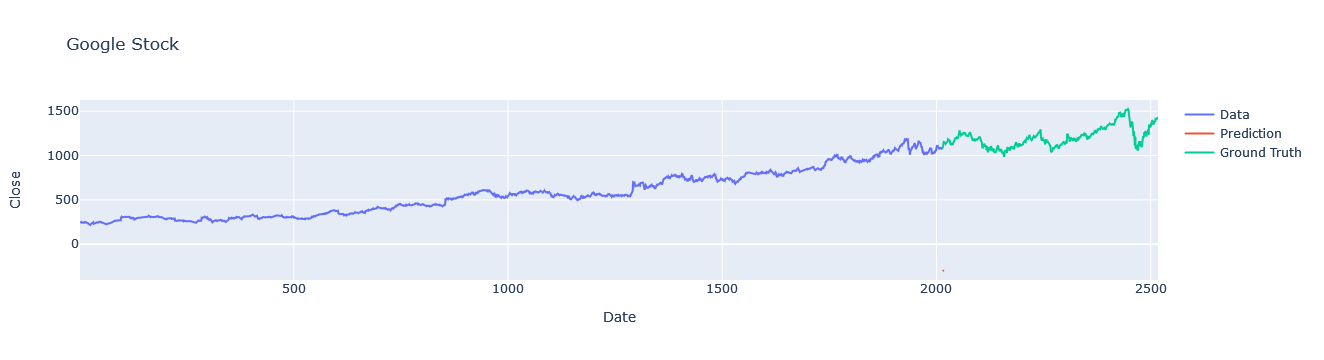

In [104]:
trace1 = go.Scatter(
    x = date_train,
    y = close_train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = close_test,
    mode='lines',
    name = 'Ground Truth'
)
layout = go.Layout(
    title = "Google Stock",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Close"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()



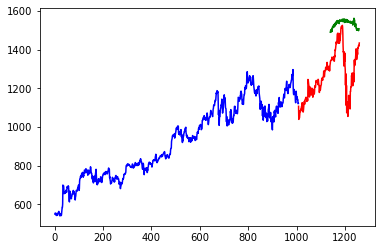

In [381]:
time_pred=range(1,len(prediction)+1)
time_pred
len_pred=len(time_pred)
len_pred
len_whole_data=len(close_data)
position=len_whole_data-len_pred
position
date_pred=range(position,len_whole_data)
date_pred

plt.plot(date_pred, prediction, color="green")
plt.plot(date_train, close_train_orig, color="blue")
plt.plot(date_test, close_test_orig, color="red")
plt.show()

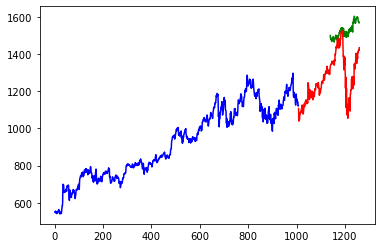

In [282]:
time_pred=range(1,len(prediction)+1)
time_pred
len_pred=len(time_pred)
len_pred
len_whole_data=len(close_data)
position=len_whole_data-len_pred
position
date_pred=range(position,len_whole_data)
date_pred

plt.plot(date_pred, prediction, color="green")
plt.plot(date_train, close_train_orig, color="blue")
plt.plot(date_test, close_test_orig, color="red")
plt.show()

# soooo, we can see that our prediction technique fits quite well - apply it to real data FINALLY !!!!!

In [ ]:
## + ještě samotná predikce

In [404]:
# forecasting

#close_data = close_data.reshape((-1))

def predict(num_prediction, model):
    prediction_list = close_data_orig[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
    
def predict_dates(num_prediction):
    last_date = df['idx'].values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

num_prediction = 30
forecast = predict(num_prediction, model)
forecast_dates = predict_dates(num_prediction)

In [405]:
forecast

array([1433.52001953, 1339.65283203, 1264.01379395,  874.38323975,
        713.05297852,  672.55657959,  622.48266602,  638.80603027,
        623.43463135,  562.86523438,  418.0078125 ,  460.59777832,
        342.64108276,  308.82141113,  333.39898682,  289.65582275,
        240.95477295,  278.52236938,  206.46234131,  186.36482239,
        175.28881836,  202.0788269 ,  154.53512573,  180.40176392,
        169.90577698,  123.28664398,  121.27941895,   98.97595978,
        121.71409607,   92.97023773,   83.43874359])

In [285]:
forecast

array([9.07242901e-01, 1.96916318e+00, 2.49396157e+00, 3.16898370e+00,
       4.24209595e+00, 6.06492424e+00, 9.33957386e+00, 1.53601942e+01,
       2.64407272e+01, 4.61938705e+01, 7.99275436e+01, 1.38052444e+02,
       2.25646622e+02, 3.59232178e+02, 5.85562012e+02, 9.59857910e+02,
       1.57379077e+03, 2.57344604e+03, 4.19368457e+03, 6.84643018e+03,
       1.13136494e+04, 1.85553105e+04, 3.03630879e+04, 4.93696562e+04,
       8.09444609e+04, 1.33586109e+05, 2.19097609e+05, 3.51692875e+05,
       5.73820875e+05, 9.35728000e+05, 1.55900075e+06])

In [318]:
forecast

array([1.43352002e+03, 9.28136259e-02, 6.40491638e+02, 1.63411414e+03,
       2.81984717e+03, 4.76815283e+03, 7.83119238e+03, 1.25979453e+04,
       1.97905801e+04, 3.10900664e+04, 4.86296094e+04, 7.59983984e+04,
       2.51506777e+04, 1.45606484e+04, 4.16580772e+00, 8.40053320e+03])

In [292]:
last_date = df['idx'].values[-1]
last_date

1259

In [290]:
close_data_orig

array([ 549.21002197,  553.95001221,  555.28997803, ..., 1420.2800293 ,
       1418.23999023, 1433.52001953])

In [295]:
forecast_dates

[Timestamp('1970-01-01 00:00:00.000001259', freq='D'),
 Timestamp('1970-01-02 00:00:00.000001259', freq='D'),
 Timestamp('1970-01-03 00:00:00.000001259', freq='D'),
 Timestamp('1970-01-04 00:00:00.000001259', freq='D'),
 Timestamp('1970-01-05 00:00:00.000001259', freq='D'),
 Timestamp('1970-01-06 00:00:00.000001259', freq='D'),
 Timestamp('1970-01-07 00:00:00.000001259', freq='D'),
 Timestamp('1970-01-08 00:00:00.000001259', freq='D'),
 Timestamp('1970-01-09 00:00:00.000001259', freq='D'),
 Timestamp('1970-01-10 00:00:00.000001259', freq='D'),
 Timestamp('1970-01-11 00:00:00.000001259', freq='D'),
 Timestamp('1970-01-12 00:00:00.000001259', freq='D'),
 Timestamp('1970-01-13 00:00:00.000001259', freq='D'),
 Timestamp('1970-01-14 00:00:00.000001259', freq='D'),
 Timestamp('1970-01-15 00:00:00.000001259', freq='D'),
 Timestamp('1970-01-16 00:00:00.000001259', freq='D'),
 Timestamp('1970-01-17 00:00:00.000001259', freq='D'),
 Timestamp('1970-01-18 00:00:00.000001259', freq='D'),
 Timestamp

In [287]:
forecast_dates

[Timestamp('1970-01-01 00:00:00.000001259', freq='D'),
 Timestamp('1970-01-02 00:00:00.000001259', freq='D'),
 Timestamp('1970-01-03 00:00:00.000001259', freq='D'),
 Timestamp('1970-01-04 00:00:00.000001259', freq='D'),
 Timestamp('1970-01-05 00:00:00.000001259', freq='D'),
 Timestamp('1970-01-06 00:00:00.000001259', freq='D'),
 Timestamp('1970-01-07 00:00:00.000001259', freq='D'),
 Timestamp('1970-01-08 00:00:00.000001259', freq='D'),
 Timestamp('1970-01-09 00:00:00.000001259', freq='D'),
 Timestamp('1970-01-10 00:00:00.000001259', freq='D'),
 Timestamp('1970-01-11 00:00:00.000001259', freq='D'),
 Timestamp('1970-01-12 00:00:00.000001259', freq='D'),
 Timestamp('1970-01-13 00:00:00.000001259', freq='D'),
 Timestamp('1970-01-14 00:00:00.000001259', freq='D'),
 Timestamp('1970-01-15 00:00:00.000001259', freq='D'),
 Timestamp('1970-01-16 00:00:00.000001259', freq='D'),
 Timestamp('1970-01-17 00:00:00.000001259', freq='D'),
 Timestamp('1970-01-18 00:00:00.000001259', freq='D'),
 Timestamp

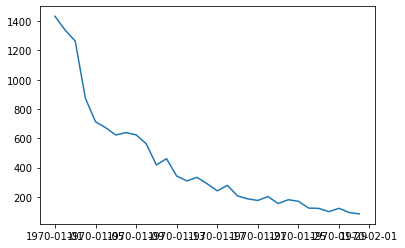

In [407]:
plt.plot(forecast_dates, forecast)
plt.show()

In [ ]:
# ------ NOT RUN----------
# podle Krishe
len(test_data)
x_input=test_data[341:].reshape(1,-1)
x_input.shape
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
temp_input

In [385]:
close_test_len=len(close_test)
close_test_len

252

In [386]:
#iii=close_test_len-15
iii=close_test_len-100
#close_test[iii:]

In [387]:
x_input=close_test[iii:].reshape(1,-1)
x_input.shape

(1, 100)

In [388]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [389]:
temp_input

[0.8682412116671022,
 0.8783242245105577,
 0.8933014284381818,
 0.9026126006363008,
 0.9138531885217988,
 0.9042677135537859,
 0.9130103241588169,
 0.9241392325162198,
 0.9539514689855354,
 0.9567235011346132,
 0.9583684500994859,
 0.959201026559214,
 0.940395854966594,
 0.9054252885958284,
 0.9244844350531175,
 0.9307798881407435,
 0.9282921987635305,
 0.9064915120150007,
 0.9570788676241234,
 0.9193160651496969,
 0.9199659383636843,
 0.9503467364260879,
 0.9535351187803506,
 0.9835403463986606,
 0.9849619363073431,
 0.9936638911019243,
 0.9883431858599588,
 0.9937654066774072,
 0.99448630360904,
 1.0,
 0.9919986142318268,
 0.9579520998943013,
 0.8933724521558272,
 0.859315773865689,
 0.8635297238286742,
 0.7868464198871369,
 0.811520778310869,
 0.859315773865689,
 0.8099671809688666,
 0.8545230983570035,
 0.786653552688784,
 0.7673405553174671,
 0.6861590825917213,
 0.7464537566495647,
 0.6811937438392658,
 0.5803134153948556,
 0.6846156492023313,
 0.5411695548715546,
 0.586923703112

In [390]:
# demonstrate prediction for next 30 days
from numpy import array

lst_output=[]
#n_steps=15
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[1.8734827]
101
1 day input [0.87832422 0.89330143 0.9026126  0.91385319 0.90426771 0.91301032
 0.92413923 0.95395147 0.9567235  0.95836845 0.95920103 0.94039585
 0.90542529 0.92448444 0.93077989 0.9282922  0.90649151 0.95707887
 0.91931607 0.91996594 0.95034674 0.95353512 0.98354035 0.98496194
 0.99366389 0.98834319 0.99376541 0.9944863  1.         0.99199861
 0.9579521  0.89337245 0.85931577 0.86352972 0.78684642 0.81152078
 0.85931577 0.80996718 0.8545231  0.78665355 0.76734056 0.68615908
 0.74645376 0.68119374 0.58031342 0.68461565 0.54116955 0.5869237
 0.55963969 0.58043526 0.53630573 0.52200889 0.59905773 0.5702304
 0.6324747  0.57900351 0.61560886 0.63148966 0.57071778 0.58587781
 0.56117296 0.65305682 0.65241724 0.67723364 0.67679697 0.68069621
 0.73636058 0.7283085  0.72844051 0.75034271 0.73221778 0.68247316
 0.72943558 0.74239214 0.74790571 0.74207731 0.70321779 0.81449597
 0.81908549 0.78925292 0.79491895 0.82144129 0.81779603 0.84201338
 0.85730529 0.87685181 0.84800429 0.

In [391]:
day_new=np.arange(1,101)  #n_steps
day_pred=np.arange(101,131) #days of prediction

#day_new=np.arange(1,16)  #n_steps
#day_pred=np.arange(16,31) #days of prediction

In [392]:
day_new

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])

In [393]:
day_pred

array([101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
       114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
       127, 128, 129, 130])

In [394]:
close_data_len=len(close_data)
#eee=close_data_len-15
eee=close_data_len-100
eee

1159

In [395]:
close_data_len

1259

In [396]:
len(lst_output)

30

In [402]:
scaler.inverse_transform(close_data[eee:])

array([[1395.10998535],
       [1405.04003906],
       [1419.79003906],
       [1428.95996094],
       [1440.0300293 ],
       [1430.58996582],
       [1439.19995117],
       [1450.16003418],
       [1479.52001953],
       [1482.25      ],
       [1483.86999512],
       [1484.68994141],
       [1466.17004395],
       [1431.72998047],
       [1450.5       ],
       [1456.69995117],
       [1454.25      ],
       [1432.7800293 ],
       [1482.59997559],
       [1445.41003418],
       [1446.05004883],
       [1475.9699707 ],
       [1479.10998535],
       [1508.66003418],
       [1510.06005859],
       [1518.63000488],
       [1513.39001465],
       [1518.72998047],
       [1519.43994141],
       [1524.86999512],
       [1516.98999023],
       [1483.45996094],
       [1419.85998535],
       [1386.31994629],
       [1390.4699707 ],
       [1314.94995117],
       [1339.25      ],
       [1386.31994629],
       [1337.7199707 ],
       [1381.59997559],
       [1314.76000977],
       [1295.739

In [403]:
lst_output

[[1.8734827041625977],
 [2.0885860919952393],
 [2.3611724376678467],
 [2.717600107192993],
 [3.183833122253418],
 [3.783669948577881],
 [4.529903888702393],
 [5.416406154632568],
 [6.423623561859131],
 [7.529574871063232],
 [8.708916664123535],
 [9.92712116241455],
 [11.141439437866211],
 [12.309528350830078],
 [13.401463508605957],
 [14.40425968170166],
 [15.316327095031738],
 [16.140329360961914],
 [16.879995346069336],
 [17.53968048095703],
 [18.124469757080078],
 [18.640071868896484],
 [19.092567443847656],
 [19.48811912536621],
 [19.832754135131836],
 [20.132184982299805],
 [20.391740798950195],
 [20.616275787353516],
 [20.810197830200195],
 [20.9774227142334]]

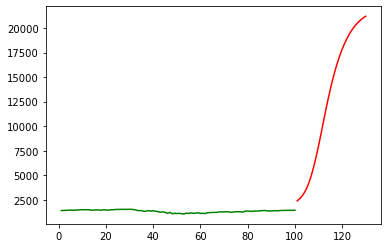

In [399]:
plt.plot(day_new,scaler.inverse_transform(close_data[eee:]), color="green")
plt.plot(day_pred,scaler.inverse_transform(lst_output), color="red")